# LG3 MLP normalization compare demo
Compare global normalization vs per-sample (RevIN-like) normalization using a simple MLP.


In [82]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# --- config ---
DATA_DIR_TRAIN = os.path.abspath(os.path.join('..', 'data', 'processed_sources', 'elec1_f2'))
DATA_DIR_TEST = os.path.abspath(os.path.join('..', 'data', 'processed_sources', 'ohsung_f2'))
TARGET_COL = 'Power'
TIN = 576  # 2 days at 5-min
TOUT = 288  # 1 day at 5-min
EPOCHS = 50
LR = 1e-3
BATCH_SIZE = 1024
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [83]:
# reproducibility
import random
import numpy as np
import torch

SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [84]:
def load_split(split, data_dir):
    path = os.path.join(data_dir, f'lg3_{split}.csv')
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    df = df.select_dtypes(include=[np.number]).dropna(how='any')
    df = df[~df.index.duplicated(keep='first')]
    return df[[TARGET_COL]].sort_index()

def build_sequences(values, seq_len, pred_len):
    total = len(values)
    max_start = total - (seq_len + pred_len) + 1
    if max_start <= 0:
        raise ValueError('Not enough rows to build sequences.')
    x = np.empty((max_start, seq_len, 1), dtype=np.float32)
    y = np.empty((max_start, pred_len), dtype=np.float32)
    for i in range(max_start):
        x[i, :, 0] = values[i : i + seq_len, 0]
        y[i] = values[i + seq_len : i + seq_len + pred_len, 0]
    return x, y

train_df = load_split('train', DATA_DIR_TRAIN)
val_df = load_split('val', DATA_DIR_TRAIN)
test_df = load_split('test', DATA_DIR_TEST)

X_train, y_train = build_sequences(train_df.to_numpy(np.float32), TIN, TOUT)
X_val, y_val = build_sequences(val_df.to_numpy(np.float32), TIN, TOUT)
X_test, y_test = build_sequences(test_df.to_numpy(np.float32), TIN, TOUT)

print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)


X_train (7289, 576, 1) y_train (7289, 288)
X_val (302, 576, 1) y_val (302, 288)
X_test (3337, 576, 1) y_test (3337, 288)


In [85]:
# Global normalization (dataset-level)
g_mean = X_train.mean(axis=(0, 1), keepdims=True)
g_std = X_train.std(axis=(0, 1), keepdims=True) + 1e-6
X_train_g = (X_train - g_mean) / g_std
X_val_g = (X_val - g_mean) / g_std
X_test_g = (X_test - g_mean) / g_std

y_mean = y_train.mean()
y_std = y_train.std() + 1e-6
y_train_g = (y_train - y_mean) / y_std
y_val_g = (y_val - y_mean) / y_std
y_test_g = (y_test - y_mean) / y_std

print('Global norm stats: mean', float(g_mean.squeeze()), 'std', float(g_std.squeeze()))


Global norm stats: mean 2.684793472290039 std 4.166021823883057


In [86]:
# Per-sample (RevIN-like) normalization using input stats
def per_sample_norm(x, y):
    # x: [B, T, 1], y: [B, T_out]
    mu = x.mean(axis=1, keepdims=True)  # [B,1,1]
    std = x.std(axis=1, keepdims=True) + 1e-6
    x_n = (x - mu) / std
    # apply same stats to y
    y_n = (y - mu[:, 0, 0][:, None]) / std[:, 0, 0][:, None]
    return x_n, y_n, mu, std

# precompute for eval convenience
X_test_ps, y_test_ps, mu_test_ps, std_test_ps = per_sample_norm(X_test, y_test)


In [87]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, out_dim),
        )

    def forward(self, x):
        return self.net(x)

def train_global_model():
    model = MLP(TIN, TOUT).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = torch.nn.MSELoss()

    X_t = torch.from_numpy(X_train_g).float().to(DEVICE).view(X_train_g.shape[0], -1)
    y_t = torch.from_numpy(y_train_g).float().to(DEVICE)
    ds = torch.utils.data.TensorDataset(X_t, y_t)
    dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(EPOCHS):
        model.train()
        total = 0.0
        for xb, yb in dl:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        if (epoch + 1) % 5 == 0:
            print(f'[global] epoch {epoch+1} | train mse {total / len(ds):.6f}')
    return model

def train_per_sample_model():
    model = MLP(TIN, TOUT).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = torch.nn.MSELoss()

    ds = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train),
        torch.from_numpy(y_train),
    )
    dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(EPOCHS):
        model.train()
        total = 0.0
        for xb, yb in dl:
            xb = xb.numpy()
            yb = yb.numpy()
            xb_n, yb_n, mu, std = per_sample_norm(xb, yb)
            xb_t = torch.from_numpy(xb_n).float().to(DEVICE).view(xb_n.shape[0], -1)
            yb_t = torch.from_numpy(yb_n).float().to(DEVICE)

            opt.zero_grad()
            pred = model(xb_t)
            loss = loss_fn(pred, yb_t)
            loss.backward()
            opt.step()
            total += loss.item() * xb_t.size(0)
        if (epoch + 1) % 5 == 0:
            print(f'[per-sample] epoch {epoch+1} | train mse {total / len(ds):.6f}')
    return model

global_model = train_global_model()
per_sample_model = train_per_sample_model()


[global] epoch 5 | train mse 0.425717
[global] epoch 10 | train mse 0.368015
[global] epoch 15 | train mse 0.315807
[global] epoch 20 | train mse 0.273897
[global] epoch 25 | train mse 0.234780
[global] epoch 30 | train mse 0.201574
[global] epoch 35 | train mse 0.176276
[global] epoch 40 | train mse 0.158267
[global] epoch 45 | train mse 0.143813
[global] epoch 50 | train mse 0.131355
[per-sample] epoch 5 | train mse 0.673437
[per-sample] epoch 10 | train mse 0.459996
[per-sample] epoch 15 | train mse 0.373650
[per-sample] epoch 20 | train mse 0.317952
[per-sample] epoch 25 | train mse 0.273201
[per-sample] epoch 30 | train mse 0.240613
[per-sample] epoch 35 | train mse 0.211141
[per-sample] epoch 40 | train mse 0.190933
[per-sample] epoch 45 | train mse 0.173890
[per-sample] epoch 50 | train mse 0.161366


In [88]:
# Evaluate on test (original scale)
global_model.eval()
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test_g).float().to(DEVICE).view(X_test_g.shape[0], -1)
    pred_g_n = global_model(X_test_t).cpu().numpy()
pred_g = pred_g_n * y_std + y_mean
mse_g = np.mean((y_test - pred_g) ** 2)
mae_g = np.mean(np.abs(y_test - pred_g))
print(f'[global] Test MSE {mse_g:.4f} | MAE {mae_g:.4f}')

per_sample_model.eval()
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test_ps).float().to(DEVICE).view(X_test_ps.shape[0], -1)
    pred_ps_n = per_sample_model(X_test_t).cpu().numpy()
# denorm with per-sample stats
pred_ps = pred_ps_n * std_test_ps[:, 0, 0][:, None] + mu_test_ps[:, 0, 0][:, None]
mse_ps = np.mean((y_test - pred_ps) ** 2)
mae_ps = np.mean(np.abs(y_test - pred_ps))
print(f'[per-sample] Test MSE {mse_ps:.4f} | MAE {mae_ps:.4f}')


[global] Test MSE 19.3190 | MAE 3.2239
[per-sample] Test MSE 1.4890 | MAE 0.8022


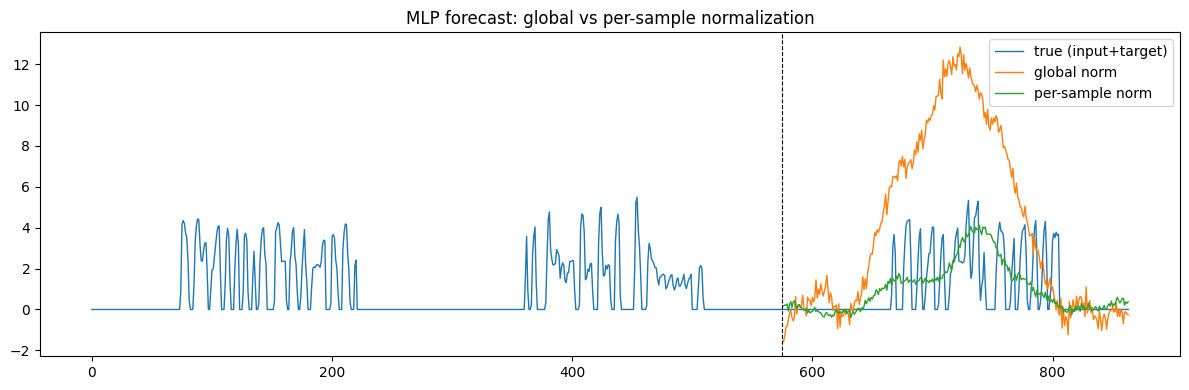

In [89]:
# Plot one example: input context + forecast
ratio = 0.4
idx = int(ratio * X_test.shape[0]) - 1
inp = X_test[idx, :, 0]
true = y_test[idx]
pred_global = pred_g[idx]
pred_ps_all = pred_ps
pred_ps_one = pred_ps_all[idx]

x_axis = np.arange(TIN + TOUT)

full_true = np.concatenate([inp, true])
full_global = np.concatenate([np.full_like(inp, np.nan), pred_global])
full_ps = np.concatenate([np.full_like(inp, np.nan), pred_ps_one])

plt.figure(figsize=(12, 4))
plt.plot(x_axis, full_true, label='true (input+target)', linewidth=1.0, color='tab:blue')
plt.plot(x_axis, full_global, label='global norm', linewidth=1.0, color='tab:orange')
plt.plot(x_axis, full_ps, label='per-sample norm', linewidth=1.0, color='tab:green')
plt.axvline(TIN - 1, color='k', linestyle='--', linewidth=0.8)
plt.legend(loc='upper right')
plt.title('MLP forecast: global vs per-sample normalization')
plt.tight_layout()
plt.show()
